# Implementation of farthest point sampling for TensorFlow


Importation of libraries:

In [1]:
import numpy as np
import tensorflow as tf
import random
import math
import matplotlib . pyplot as plt
import numpy as np
from scipy.spatial import distance
from datetime import datetime

Usefull functions:

In [4]:
def batch_dist_mat_gen(A, B):
    # A shape is (N, P_A, C), B shape is (N, P_B, C)
    # D shape is (N, P_A, P_B)
    r_A = tf.math.reduce_sum(A * A, axis=2, keepdims=True)
    r_B = tf.math.reduce_sum(B * B, axis=2, keepdims=True)
    m = tf.matmul(A, tf.transpose(B, perm=(0, 2, 1)))
    D = r_A - 2 * m + tf.transpose(r_B, perm=(0, 2, 1))
    return D


def gather_pts_gen(pts, D):
    # Gathering elements of pts accordind to a distance matrix
    distances, point_indices = tf.math.top_k(-D, k=D.shape[2]-1, sorted=True)
    query = tf.math.top_k(-D, k=D.shape[2]-1, sorted=True).indices
    n = tf.shape(pts)[0]
    ii = tf.tile(tf.range(n)[:, tf.newaxis], (1, point_indices.shape[2]))
    query = tf.squeeze(query)
    idx = tf.stack([ii, query], axis=-1)
    
    return tf.gather_nd(pts, idx)


def gather_gen(pts, ind):
    # Gathering elements of pts accordind to an indices matrix
    query = ind
    n = tf.shape(pts)[0]
    ii = tf.tile(tf.range(n)[:, tf.newaxis], (1, ind.shape[1]))
    ii = tf.cast(ii, dtype=tf.int32)
    query = tf.squeeze(query)
    query = tf.cast(query, dtype=tf.int32)
    query = tf.expand_dims(query, axis=1)
    idx = tf.stack([ii, query], axis=-1)
    
    return tf.gather_nd(pts, idx)

In [5]:
def build_fps(points, samp):
    '''
    Farthest point sampling (FPS) is a technique used to sample a point cloud efficiently.
    It is used in 3D object detection.
    This is the implementation for keras layers
    :param points: point cloud
    :param samp: number of samples
    :return: samples of in the point cloud
    Author: Elie Ghanassia on 02/02/2022
    '''

    nbp = points.shape[1]
    pts = points # ------------------------------------------------ Copy point cloud
    first_point_ind = random.randint(0,nbp)  # -------------------- Select randomly first point
    first_point = tf.gather(pts, indices=first_point_ind, axis=1)
    first_point = tf.expand_dims(first_point, axis=1)
    dist_mat = batch_dist_mat_gen(first_point,pts) # ------------- Calculate distances matrix   
    pts = gather_pts_gen(pts, dist_mat) # ------------- Delete first point from pts
    maxi = tf.math.argmax(dist_mat, axis=2) # --------------------- Take argmax
    second_point = gather_gen(pts, maxi) # --------- Select second point using argmax
    D = batch_dist_mat_gen(second_point,pts) # ------- Delete second point from pts 
    pts = gather_pts_gen(pts, D)
    
    # Tensor of nodes:
    nodes_mat = tf.keras.layers.concatenate([first_point,second_point],axis=1)

    # Tensor of distances between remaining points and nodes:
    dist_mat = batch_dist_mat_gen(pts, nodes_mat)

    # Iteration over number of samples:
    for i in range(2, samp):

        min_mat = tf.math.reduce_min(dist_mat, axis=2)
        max_mat = tf.math.argmax(min_mat, axis=1)
        max_mat = tf.expand_dims(max_mat, axis=1)
        point = gather_gen(pts, max_mat) # -------------- New node
        dist_point = batch_dist_mat_gen(pts, point) # ------------------ Distances between remaining points and the new node
        dist_mat = tf.keras.layers.concatenate([dist_mat,dist_point],axis=2) # -- Upgrade tensor of distances
        nodes_mat = tf.keras.layers.concatenate([nodes_mat,point],axis=1) # -- Upgrade tensor of nodes
        D = batch_dist_mat_gen(point,pts) # ------- Delete point from pts 
        pts = gather_pts_gen(pts, D)
        dist_mat = gather_pts_gen(dist_mat, D) # -------------- Deleting new node from tensor of distances 
          
        
    print('fps finished, shape of results:', nodes_mat.shape)
    return nodes_mat

Example with a random tensor:

In [6]:
# Number of samples:
N = 200 
now = datetime.now()
unp = np.random.rand(32,2048,3).astype(np.float32)
BATCH_SIZE=unp.shape[0]
new_n = build_fps(unp, N)
now1 = datetime.now()
print(now1-now)

fps finished, shape of results: (32, 200, 3)
0:00:02.857410


<ipython-input-7-b5f42fa21591>:22: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  ax.scatter(x, y, z, marker='o', c='', edgecolors='b', s=50)


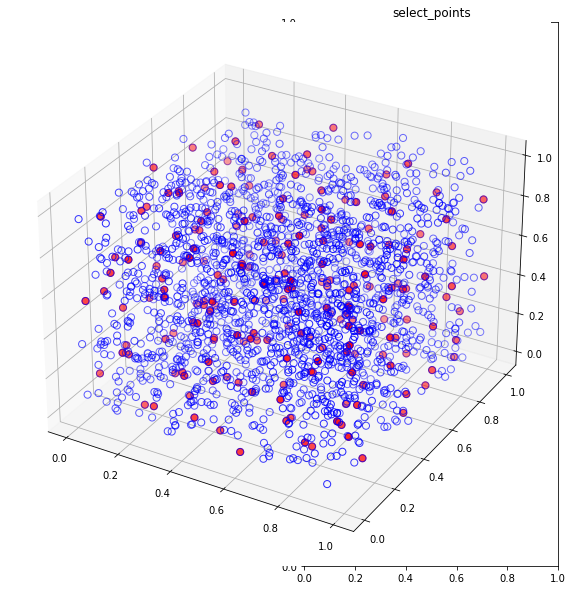

In [7]:
# Selection of the data:
select = 10


xyz = unp[select]
new_xyz = new_n[select]

x = xyz[:,0]
y = xyz[:,1]
z = xyz[:,2]

new_x = new_xyz[:,0]
new_y = new_xyz[:,1]
new_z = new_xyz[:,2]

 
fig = plt.figure(figsize=(10,10))
plt.subplot (122) 
plt.title('select_points')
ax = fig.add_subplot(projection='3d')

ax.scatter(x, y, z, marker='o', c='', edgecolors='b', s=50)
ax.scatter(new_x, new_y, new_z, marker='o', c='red', edgecolors='r', s=50)
plt.show()